In [ ]:
# Import the relevant modules
import pandas as pd
from itertools import product
from collections import Counter
import numpy as np 
import torch
from torchvision.datasets import ImageFolder 
import torchvision.utils
from torchvision.transforms import RandomHorizontalFlip
from torchvision import transforms
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import time
import os
from os.path import exists
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Create a device object that refers to the default CUDA-capable GPU if available
# If a CUDA-capable GPU is not available run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check device
print(device)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set the current working directory
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Create a new directory to store script outputs
os.makedirs('ca1.2', exist_ok=True)

# Check wd has been set correctly
os.getcwd()

Model class definitions

Create ResNet18 Architecture 

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, padding=1, down_sample=None):

        super().__init__(ResidualBlock, self)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(

            # First convolution 
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding, bias=False), 

            # Batch normalisation after first convolution
            nn.BatchNorm2d(out_channels),

            # Add a ReLU activation layer 
            nn.ReLU(inplace=True))
        
        self.conv2 = nn.Sequential(

            # Second convolution 
            # Retain spatial dimensions (stride=1)
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=padding, bias=False),

            # Batch normalisation after second convolution
            nn.BatchNorm2d(out_channels))
        
        # Downsample in the first block of each stage 
        # Conditionally downsamples based on stride/channels
        # Can be None or nn.sequential 
        self.downsample = down_sample

    # Applies the main convolutional path and skip connection.
    # Handles downsampling if needed, then adds both paths and applies ReLU.
    def forward(self, x):

        # Record input prior to convolutional layer
        identity = x

        # Pass input through first convolutional layer
        out = self.conv1(x)

        # Pass output from first convolutional layer to second convolutional layer
        out = self.conv2(out)

        # If the identity path and main path dimensions don't match, the identity path must be downsampled
        if self.downsample is not None:

            # Apply downsampling to identity path
            identity = self.downsample(x)

        # Apply the skip connection
        # Learn only the difference (residual) between the main path and the identity paths
        out += identity

        # Apply the Relu activation function
        out = self.relu(out)

        # Return the output of the residual block
        return out

In [ ]:
# Create a class called MyResNet18 which inherits from the nn.Module class (base class for all neural networks)
class MyResNet18(nn.Module):
    
    # Add parameters features and default argument total_cls=23 to constructor method definition
    def __init__(self, in_channels=3, total_cls=23):
        
        # Initialise the partent class nn.Module
        super(MyResNet18, self).__init__()


        # Takes image of shape 224 x 224 and outputs feature maps of shape 112 x 112 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        )

        # Create a max pooling layer with a 3x3 kernel and a stride of 2
        self.max_pl = nn.MaxPool2d(kernel_size=3, stride=2) 

        # Create conv2 to conv_5 layer types 
        self.layer1 = self._make_blk_layers(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_blk_layers(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_blk_layers(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_blk_layers(256, 512, num_blocks=2, stride=2)


        # Create a global average pooling layer to apply to each of the 512 feature maps to compress each 7x7 map down to a single scaler (average of 49 values in the map)
        self.glbl_avgpl = nn.AdaptiveAvgPool2d((1,1))

        # Create a single fully connected layer 
        self.classifier = nn.Linear(512, total_cls)

    # Helper function to create a sequence of residual blocks (main path convolutions),
    # with optional downsampling in the first block to reduce spatial dimensions.
    def _make_blk_layers(self, in_channels, out_channels, total_blks, stride):

        blk_layers = []

        downsample = None

        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(

                # Downsample the identity path to the same dimensions as the main path
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),

                # Normalise the output of the convolution (just like main path)
                nn.BatchNorm2d(out_channels)
            )
        
        # Create first block layer with downsampling
        blk_layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # Create remaining blocks with no downsampling
        for _ in range(1, total_blks):
            blk_layers.append(ResidualBlock(in_channels, out_channels))


        return nn.Sequential(*blk_layers)
 
    def forward(self, x):

        x = self.conv1(x)

        x = self.max_pl(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = self.glbl_avgpl(x)

        x = torch.flatten(x, start_dim=1)

        x = self.classifier(x)

        return x

Create VGG-D Architecture (16 weight layers)

In [ ]:
# Create a class called MyVggNet16 which inherits from the nn.Module class (base class for all neural networks)
class myVggNet16(nn.Module):

    def __init__(self, in_channels=3, total_cls=23):
        super().__init__(myVggNet16, self)

        self.features = self._make_layers(in_channels)

        self.classifier = nn.Sequential(

            # FCC Layer 1
            nn.Linear(512, 4096),

            nn.ReLU(inplace=True),

            # Randomly disable 50% of neurons during training - prevent network from depending too heavily on any single path or weight
            nn.Dropout(p=0.5),

            # FCC Layer 2
            nn.Linear(4096, 4096),

            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),

            # FCC Layer 3
            nn.Linear(4096, total_cls)
        )



    def _make_layers(in_channels=3, kernel_size=3):

        # List of tuples that provide the number of layers and kerenel size for each layer type
        cfg = [(2,64), (2, 128), (3, 256), (3, 512), (3, 512)]

        # Create a list to store the convolutional and pooling layers
        layers = []

        for num_convs, out_channels in cfg:
            for i in range(num_convs):
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        # Pass input through convolutional and pooling layers to perform feature learning
        x = self.features(x)
        
        # Flatten the output 
        x = torch.flatten(x, start_dim=1)

        x = self.classifier(x)

        return x 


Functions for training and evaluation

In [ ]:
def train_model(fold, train_dl, model,model_name, loss_fn, optimizer, schedular,config_name, epochs=50):

	epoch_losses = []
	epoch_accuracies = []


	# Record the start time prior to the first epoch commencing
	start_time = time.time()

	# Iterate through the current training fold 50 times 
	for epoch in tqdm(range(1, epochs+1), desc=f'Training fold {fold}', leave=True):

		model.train()
		
		# Initialise variables to their respective starting values
		loss_trckr = 0
		total_correct = 0
		total_samples = 0
		total_batches = len(train_dl)


		# Iterate through each index and corresponding image tensor and label tensor
		for batch, (X, y) in enumerate(train_dl):
			# Move inputs and labels to GPU
			X = X.to(device)
			y = y.to(device)

			# Perform forward pass to compute predictions and calcluate the loss
			logits = model(X)
			
			loss = loss_fn(logits, y)

			preds = logits.argmax(1)

			# Calculate the number of correct predictions for the batch
			total_correct += (preds == y).sum().item()

			# Update the total samples processed
			total_samples += y.size(0)
			
			# Perform backpropogation

			# Clear gradients from the previous batch
			optimizer.zero_grad()

			# Compute gradients for the current batch
			loss.backward()

			# Update the models parameters using the gradients 
			optimizer.setp()

			# Update the loss for the batch
			loss_trckr += loss.item()

		# Calculate the average loss for one epoch 
		epoch_loss = loss_trckr/total_batches

		# Calculate the accuracy for the epoch
		epoch_accuracy =  total_correct / total_samples

		epoch_losses.append(epoch_loss)

		epoch_accuracies.append(epoch_accuracy)

		if isinstance(schedular, torch.optim.lr_scheduler.ReduceLROnPlateau):
			# Choose the right metric for the configuration 

			# ResNet configuration
			if config_name == 'config_A':
				schedular.step(epoch_loss)
			
			# VGGNet configuration
			elif config_name == 'config_B':
				schedular.step(epoch_accuracy)
	
	# Record the time taken to train the model on the fold
	elapsed_time = (time.time() - start_time)

	fold_loss = sum(epoch_losses) / len(epoch_losses)

	fold_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)

	final_lr = optimizer.param_groups[0]['lr']

	# Report the training stats for the fold
	tqdm.write(f"Completed fold {fold} for {model_name} + {config_name}")
	tqdm.write(f"[Fold {fold}] Acc: {fold_accuracy:.4f} | Loss: {fold_loss:.4f} | Time: {elapsed_time:.2f}s | Final LR: {final_lr:.6f}")

	# Return the total loss and accuracy for the fold
	return fold_loss, fold_accuracy, final_lr, elapsed_time, epoch_accuracies, epoch_losses


In [ ]:
def evaluate_model(model, evaluate_dl, loss_fn, fold):
    
    #
    all_preds = []
    all_labels = []
    eval_loss = 0
    total_correct = 0
    total_samples = 0

    # Set model to evaluation mode
    model.eval()

    with torch.no.grad():
        for X, y in evaluate_dl:

            X = X.to(device)
            y = y.to(device)

            logits = model(X)

            loss = loss_fn(logits, y)

            eval_loss += loss.item()
            

            preds = logits.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            total_correct += (preds == y).sum().item()

            total_samples += y.size(0)

    # Compute evaluation metrics 
    eval_accuracy = accuracy_score(all_labels, all_preds)
    eval_f1 = f1_score(all_labels, all_preds, average='macro')
    eval_precis = precision_score(all_labels, all_preds, average='macro')
    eval_reacll = recall_score(all_labels, all_preds, average='macro')
    eval_avg_loss = eval_loss / total_samples


    tqdm.write(f"[Fold {fold} Evaluation] Acc: {eval_accuracy:.4f} | F1: {eval_f1:.4f} | Loss: {eval_avg_loss:.4f}")


    return eval_accuracy, eval_f1, eval_precis, eval_reacll, eval_avg_loss, all_preds, all_labels


In [ ]:
# Use Kaiming initialisation to sample weights from a uniform distribution
# Ensures diversity in weights and avoids bias toward any one range
def kaiming_weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_uniform_(model.weight)
        
        # Set bias to 0 for reproducability 
        if model.bias is not None:
            nn.init.constant_(model.bias, 0)

Functions for visualisation

In [ ]:
# Function to inverse transform the normalised images back to the original pixel values for plotting
# Uses the RGB means and stds used to normalise the pixels
def inv_normalise(means, stds, images):
    # Create a 4-D tensor to store the transformed images
    rev_images = torch.zeros_like(images)
    # Iterate through each image
    for img in range(images.size()[0]):
        # Iterate through each colour channel of that image and apply the inverse transformation
        for ch in range(images.size()[1]):
            rev_images[img][ch] = images[img][ch] * stds[ch] + means[ch]

    # Return the transformed 4-D tensor for plotting
    return rev_images

In [ ]:
def visualise_batch(train_loader, class_names, ch_mean, ch_std):

    images, labels = next(iter(train_loader))

    unnorm_images = inv_normalise(means=ch_mean, std=ch_std, images=images)

    # Display the batch size and image shape
    print(f'The image batch size is {images.size()[0]}. Each image has a shape of {images.size()[1:5]}.\n')

    # Create a square figure to hold the grid of images
    figure = plt.figure(figsize=(10,10))

    # Define the number of rows and cols in the grid
    cols, rows = 4,8

    # Loop throuugh the batch of images
    n_images = min(len(images), rows * cols)
    for i in range(n_images):
        # Add a subplot to the figure
        figure.add_subplot(rows, cols, i+1)
        # Set the title as the class name for the current image
        plt.title(class_names[labels[i]])
        plt.axis("off")
        # Display the image (re-order the channels from [C, H, W] to [H, W, C])
        plt.imshow(unnorm_images[i].permute(1,2,0))
        # Adjust suplot to avoid overlap
        figure.tight_layout()

# Display the complete batch of images
plt.show()

Employ Stratified Cross Validation for K-folds for a robust training and evaluation routine 

In [ ]:
def perform_skf(skf_obj, labels, train_ds, model_name, model_fn, optim_fn, sched_fn, config_name, ds_classes, ch_mean, ch_std, data_transform):

	# Create a list to store the evaluation metrics for each model and fold
	results = []


	for fold, (sub_train_idx, sub_val_idx) in enumerate(skf_obj.split(X=labels, y=labels)):

		# Instantiate a new model for the fold
		model = model_fn()

		# Apply Kaiming weight initialisation 
		model.apply(kaiming_weights_init)

		# Send model parameters to GPU
		model = model.to(device)

		optimizer = optim_fn(model)

		schedular = sched_fn(optimizer)

		# Calculate class weights for the fold based on fold class distribution
	    # Use inverse frequency as a method of rescaling class weights to penalise mitakes on the minority class more heavily 
	    
		# Get the class labels corresponding to the training fold
		train_labels = [labels[i] for i in sub_train_idx]

		# Count class occurances Counter({'0': 2, '1':5})
		cls_counts = Counter(train_labels)

		# Calculate the total number of samples for the fold
		total_samples = sum(cls_counts.values())

		# Get the number of unique classes within the whole train dataset 
		# Avoids issue of training fold not having the same classes as evaluation fold
		num_classes = len(set(labels))

		# Calculate inverse frequency 
		# If a class is not present in the training fold, set count to 1
		# to avoid a division by zero error and ensure a full-length weight list
		corrctd_weights = [total_samples / (num_classes * cls_counts.get(cls, 1)) for cls in range(num_classes)]

		# Convert to a tensor and move to GPU
		class_weights = torch.tensor(corrctd_weights, dtype=torch.float).to(device)

		# Create weight loss function for the fold
		loss_fn = nn.CrossEntropyLoss(weight=class_weights)

		# Create a fold using the specified indicies
		train_sub = Subset(train_ds, sub_train_idx)
			
		val_sub = Subset(train_ds, sub_val_idx)
	
		# Apply data augmentation, normalisation and tensor conversion
		train_sub.dataset.transform = data_transform['train']

		val_sub.dataset.transform = data_transform['test']
	
		# Create a pair of train and validate dataloaders for the fold

		train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
		val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

		# Visualise one batch of the training dataset
		visualise_batch(train_loader, ds_classes, ch_mean, ch_std)

		# Train model for 50 epochs on fold
		fold_train_loss, fold_train_accuracy, fold_final_lr, fold_train_time, epoch_accuracies, epoch_losses = train_model(fold, train_loader, model,model_name, loss_fn, optimizer, schedular,config_name, epochs=50)

		# Evaluate the model on the evaluation fold
		eval_accuracy, eval_f1, eval_precis, eval_recall, eval_avg_loss, all_preds, all_labels = evaluate_model(model, val_loader, loss_fn, fold)

		# Check the directory exsists
		os.makedirs('outputs', exist_ok=True)

		# Save the training stats for each model for later use
		np.save(f'outputs/{model_name}_{config_name}_fold{fold}_train_losses.npy', epoch_losses)
		np.save(f'outputs/{model_name}_{config_name}_fold{fold}_train_accuracies.npy', epoch_accuracies)

		# Save model predictions and true labels
		np.save(f'outputs/{model_name}_{config_name}_fold{fold}_preds.npy', all_preds)
		np.save(f'outputs/{model_name}_{config_name}_fold{fold}_labels.npy', all_labels)

		# Save the model's state dictionary 
		save_name = f'{model_name}_{config_name}_fold{fold}.pt'
		save_path = os.path.join('saved_models', save_name)
		torch.save(model.state_dict(), save_path)

		results.append({
			'fold': fold,
			'model': model_name,
			'config': config_name,
			'eval_accuracy': eval_accuracy,
			'eval_f1_macro': eval_f1,
			'eval_precision_macro': eval_precis,
			'eval_recall_macro': eval_recall,
			'eval_loss': eval_avg_loss,
			'save_path': save_path,
			'train_accuracy':fold_train_accuracy,
			'train_loss': fold_train_loss,
			'final_lr': fold_final_lr,
			'training_time_sec': fold_train_time
		})


	# Return the results
	return results

In [ ]:
def evaluate_final_testset(model, test_loader):

    test_all_preds = []
    test_all_labels = []
    test_loss = 0
    
    model.eval()
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():

        for X, y in test_loader:

            X = X.to(device)
            y = y.to(device)

            logits = model(X)

            loss = loss_fn(logits, y)

            test_loss += loss.item()

            preds = logits.argmax(1)

            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(y.cpu().numpy())

    # Compute evaluation metrics 
    test_accuracy = accuracy_score(test_all_labels, test_all_preds)
    test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')
    test_precis = precision_score(test_all_labels, test_all_preds, average='macro')
    test_reacll = recall_score(test_all_labels, test_all_preds, average='macro')
    test_avg_loss = test_loss / len(test_loader.dataset)

    # Return
    return {
        'test_loss': test_avg_loss,
        'test_accuracy': test_accuracy,
        'test_f1_macro': test_f1,
        'test_precision_macro': test_precis,
        'test_recall_macro': test_reacll,
        'preds': test_all_preds,
        'labels': test_all_labels
    }

Dataset loading and transformations

Model configuration dictionaries 

ResNet 
- Learning rate starts from 0.1 and is divided by 10 when the error plateaus 
- Weight decay: 0.0001 and a momentum=0.9

VGGNet 
- Learning rate starts from 0.01 and is divided by 10 when validation set accuracy stops improving
- Weight decay: 0.0005 and momentum=0.9

In [ ]:
# Create configuration dictionary
configs = {
    "config_A": {
        "name": "config_A",
        "optim_fn": lambda model: torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9),
        "sched_fn": lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", factor=0.1, patience=5)
    },
    "config_B": {
        "name": "config_B",
        "optim_fn": lambda model: torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9),
        "sched_fn": lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="max", factor=0.1, patience=5)
    }
}


# Create model dictionary
models = {
"ResNet": {
'name': 'ResNet18',
'model_fn': lambda: MyResNet18()
},
"VGGNet":{
'name': 'VGGNet16',
'model_fn':lambda: myVggNet16()
}
} 


cfg = [
    [models[m]['name'], models[m]['model_fn'], configs[c]['name'], configs[c]['optim_fn'], configs[c]['sched_fn']]
    for m, c in product(models, configs)
]

In [ ]:
def get_model(name):
    if name == 'ResNet18':
        return MyResNet18()
    
    elif name == 'VGGNet16':
        return myVggNet16()
    
    else:
        raise ValueError('Unknown model name')

In [ ]:
# Load dataset with no transforms
dataset = ImageFolder(root='sea_animals_image_ds')

In [ ]:
class_counts = Counter(dataset.targets)
for class_idx, count in class_counts.items():
    print(f"Class: {dataset[class_idx]} | Count: {count}")

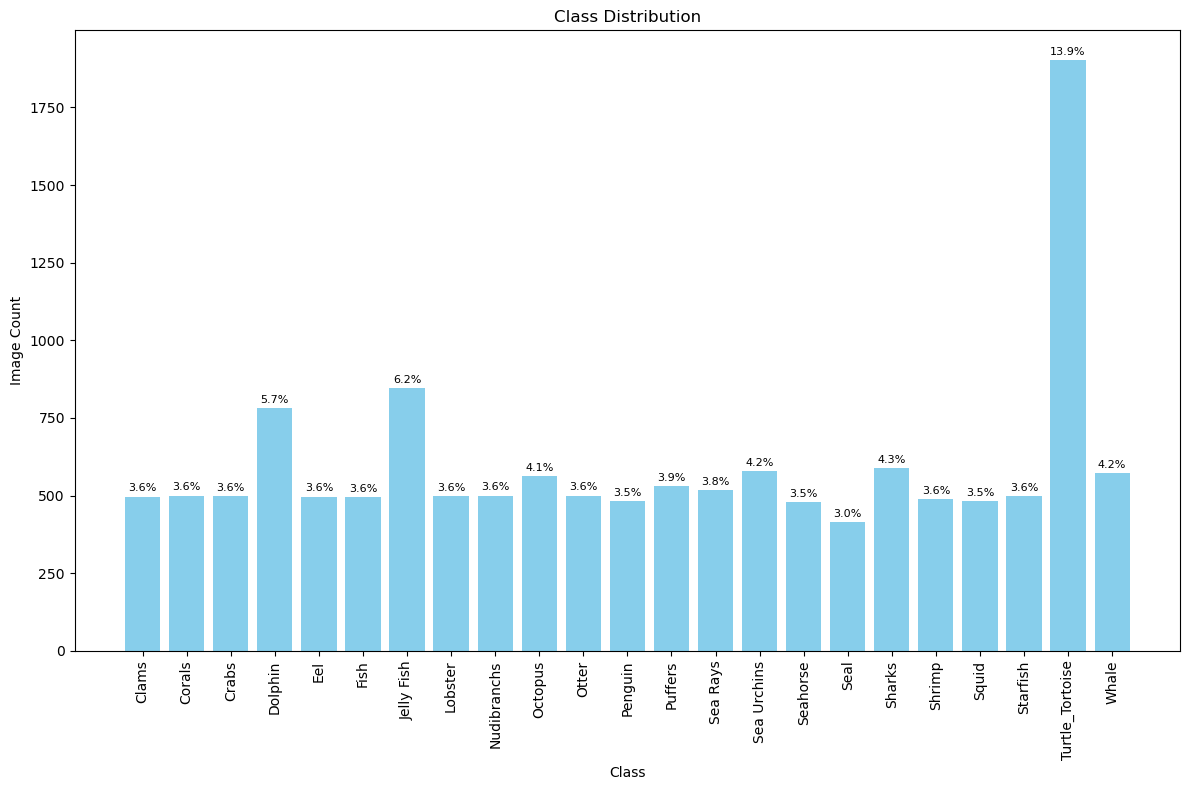

In [ ]:
# Map class indices to names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_counts_named = {idx_to_class[i]: count for i, count in class_counts.items()}

# Calculate percentages
total = sum(class_counts_named.values())
class_percentages = {k: (v / total) * 100 for k, v in class_counts_named.items()}

# Plot
plt.figure(figsize=(12, 8))
sorted_counts = dict(sorted(class_counts_named.items(), key=lambda x: x[1], reverse=True))
bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Class Distribution')

# Add % labels above bars
for bar, percent in zip(bars, class_percentages.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
             f'{percent:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Pre-process: Calculate the per-channel mean and std for normalisation using the full dataset

In [ ]:
# Load dataset WITHOUT normalisation
minimal_prepro = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

dataset = ImageFolder(root='sea_animals_image_ds',transform=minimal_prepro)
norm_loader = DataLoader(minimal_prepro, batch_size=64, shuffle=False, num_workers=2)

# Initialize sums
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(norm_loader):
    batch_samples = data.size(0)  # batch size (may be smaller in last batch)
    data = data.view(batch_samples, data.size(1), -1)  # reshape to (B, C, H*W)
    mean_rgb += data.mean(2).sum(0)
    std_rgb += data.std(2).sum(0)
    nb_samples += batch_samples

mean_rgb /= nb_samples
std_rgb /= nb_samples

print("Per-channel mean:", mean_rgb)
print("Per-channel std:", std_rgb)

100%|██████████| 215/215 [01:17<00:00,  2.79it/s]

Per-channel mean: tensor([0.3233, 0.4088, 0.4206])
Per-channel std: tensor([0.1811, 0.1834, 0.1819])


In [ ]:
data_transform = {'train': transforms.Compose([
    transforms.Resize((256, 256)),
    RandomHorizontalFlip(),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)]),

'test': transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])}

In [ ]:
# Randomly split the dataset into train (80%) and test (20%)

generator=torch.Generator().manual_seed(42)

# Calculate the number of samples equating to 80 percent of the dataset
train_size = int(0.8 * len(dataset))

# Calculate the remaining number of samples (20 percent)
test_size = len(dataset) - train_size

# Randomly select samples based on respective dataset sizes 
train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=generator)

In [ ]:
# Create a test dataloader 
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
# Perform K-Fold Cross Validation (CV) on the training set

all_results = []

# train_ds is a Subset with limited methods (compared to the ImageFolder class)
# Use indicies from the train dataset to locate the corresponding class indicies in the full dataset
labels = [dataset.targets[i] for i in train_ds.indices]

# Create a skf object, with shuffling to create varied folds that are reproducable  
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each model combination
for model_name, model_fn, config_name, optim_fn, sched_fn in cfg:

    results = perform_skf(skf, labels, train_ds, model_name, model_fn, optim_fn, sched_fn, config_name, dataset.classes, mean_rgb, std_rgb, data_transform)
    
    # Save the results for the strategy
    all_results.extend(results)

# Convert results into a dataframe to select the best model for each config
results_df = pd.DataFrame(all_results)	

# Group by model type and configuration (4 variations) and pick the best based on F1 score
best_models = results_df.loc[results_df.groupby(['model', 'config'])['f1_macro'].idxmax()]

# Iterate through each row containing a 'best model':
# 1.) Recreate the model instance 
# 2.) Load the saved weights into the model instance 
# 3.) Save the model to a new directory 
# Reload and save each best model
for _, row in best_models.iterrows():
    model = get_model(row['model'])  # or use model_fn if preserved
    model.load_state_dict(torch.load(row['save_path']))
    torch.save(model.state_dict(), f"best_models/{row['model']}_{row['config']}_BEST.pt")

In [ ]:
final_test_results = []

# Iterate through each row in the best models dataframe: 
# 1.) Use the get_model function to instantiate a new model with the specified architecture
# 2.) Load the model parameters from the corresponding state dictionary
# 3.) Move model to GPU

for _, row in tqdm(best_models.iterrows(), total=len(best_models)):
    model = get_model(row['model'])
    model.load_state_dict(torch.load(row['save_path']))
    model.to(device)

    result = evaluate_final_testset(model, test_loader)

    # Print clean test summary per model
    tqdm.write(
        f"[{row['model']} + {row['config']}] "
        f"Accuracy: {result['test_accuracy']:.4f} | "
        f"F1: {result['test_f1_macro']:.4f} | "
        f"Loss: {result['test_loss']:.4f}"
    )

    final_test_results.append({
        "model": row['model'],
        "config": row['config'],
        "test_accuracy": result["test_accuracy"],
        "test_f1_macro": result["test_f1_macro"],
        "test_precision_macro": result["test_precision_macro"],
        "test_recall_macro": result["test_recall_macro"],
        "test_loss": result["test_loss"],
        "preds": result["preds"],
        "labels": result["labels"]
    })

In [ ]:
# Save test results (minus preds/labels) as CSV
test_results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ["preds", "labels"]}
    for r in final_test_results
])
test_results_df.to_csv("outputs/final_test_metrics.csv", index=False)

# Save preds/labels separately for reproducibility or confusion matrix plotting
for r in final_test_results:
    base_name = f"{r['model']}_{r['config']}"
    np.save(f"outputs/{base_name}_test_preds.npy", r["preds"])
    np.save(f"outputs/{base_name}_test_labels.npy", r["labels"])
